In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [3]:
# Load image
im = cv2.imread("./image4.jpg")

# Chuyển ảnh về không gian màu xám
im_gray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)

# Giảm nhiễu làm cho các cạnh sắc nét hơn
noise_removal = cv2.bilateralFilter(im_gray,9,75,75)
# Cân bằng sáng tối hình ảnh
equal_histogram = cv2.equalizeHist(noise_removal)

# Biến đổi hình thái ảnh làm cho edge trở nên sắc nhọn
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(5,5))
morph_image = cv2.morphologyEx(equal_histogram,cv2.MORPH_OPEN,kernel,iterations=20)

# Xóa background, tách biệt background và vùng sáng
sub_morp_image = cv2.subtract(equal_histogram,morph_image)
ret,thresh_image = cv2.threshold(sub_morp_image,0,255,cv2.THRESH_OTSU)

# Nhận dạng edge bằng thuật toán Canny
canny_image = cv2.Canny(thresh_image,250,255)

# Dilate các edge 
kernel = np.ones((3,3), np.uint8)
dilated_image = cv2.dilate(canny_image,kernel,iterations=1)

In [4]:
contours, hierarchy = cv2.findContours(dilated_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours= sorted(contours, key = cv2.contourArea, reverse = True)[:10]
screenCnt = None
for c in contours:
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.05 * peri, True) 
    if len(approx) == 4:
            screenCnt = approx
            break

In [5]:
screenCnt

array([[[298, 541]],

       [[305, 590]],

       [[545, 592]],

       [[537, 541]]], dtype=int32)

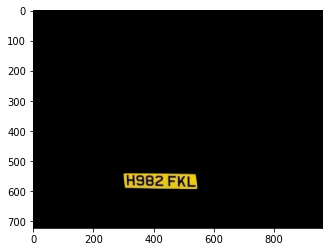

In [6]:
mask = np.zeros(im_gray.shape, np.uint8)
new_image = cv2.drawContours(mask, [screenCnt], 0,255, -1)
new_image = cv2.bitwise_and(im, im, mask=mask)
plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))

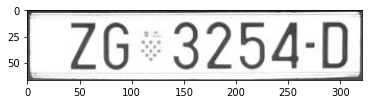

In [99]:
(x,y) = np.where(mask==255)
(x1, y1) = (np.min(x), np.min(y))
(x2, y2) = (np.max(x), np.max(y))
cropped_image = im_gray[x1:x2+1, y1:y2+1]
plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))

In [100]:
roi = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)
roi_gray = cv2.cvtColor(roi,cv2.COLOR_BGR2GRAY)
roi_blur = cv2.GaussianBlur(roi_gray,(3,3),1)
ret,thre = cv2.threshold(roi_blur,120,255,cv2.THRESH_BINARY_INV)
kerel3 = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))
thre_mor = cv2.morphologyEx(thre,cv2.MORPH_DILATE,kerel3)
cont,hier = cv2.findContours(thre_mor,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)

[4.0, 32.0, 150.0, 151.5, 472.5, 637.0, 419.5, 473.0, 407.0, 1019.5, 416.0, 416.5, 841.0]


C:\Users\PC\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  app.launch_new_instance()


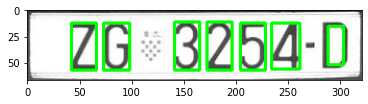

In [101]:
areas_ind = {}
areas = []
for ind,cnt in enumerate(cont) :
    area = cv2.contourArea(cnt)
    areas_ind[area] = ind
    areas.append(area)
print(areas)
    
areas = sorted(areas,reverse=True)[2:9]
contours = []
for i in areas:
    (x,y,w,h) = cv2.boundingRect(cont[areas_ind[i]])
    cv2.rectangle(roi,(x,y),(x+w,y+h),(0,255,0),2)
    contours.append(cont[areas_ind[i]])

contours = np.array(contours)

plt.imshow(cv2.cvtColor(roi,cv2.COLOR_BGR2RGB))

In [105]:
contours = sorted(contours, key=lambda ctr: cv2.boundingRect(ctr)[0])

In [52]:
import cv2
import numpy as np
from skimage.feature import hog
from sklearn.svm import LinearSVC
from keras.datasets import mnist
from sklearn.metrics import accuracy_score
#load data
(X_train,y_train),(X_test,y_test) = mnist.load_data()

In [53]:
X_train_feature = []
for i in range(len(X_train)):
    feature = hog(X_train[i],orientations=9,pixels_per_cell=(14,14),cells_per_block=(1,1),block_norm="L2")
    X_train_feature.append(feature)
X_train_feature = np.array(X_train_feature,dtype = np.float32)

#cho x_test
X_test_feature = []
for i in range(len(X_test)):
    feature = hog(X_test[i],orientations=9,pixels_per_cell=(14,14),cells_per_block=(1,1),block_norm="L2")
    X_test_feature.append(feature)
X_test_feature = np.array(X_test_feature,dtype=np.float32)

In [54]:
model = LinearSVC(C=10)
model.fit(X_train_feature,y_train)
y_pre = model.predict(X_test_feature)
print(accuracy_score(y_test,y_pre))

0.8988


C:\Users\PC\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


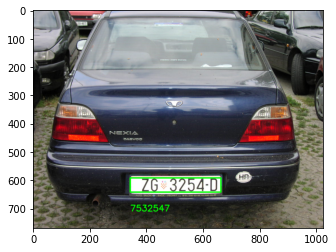

In [106]:
text = ""
for contour in contours:
    (x,y,w,h) = cv2.boundingRect(contour)
    roi = thre[y:y+h,x:x+w]
    roi = np.pad(roi,(20,20),'constant',constant_values=(0,0))
    roi = cv2.resize(roi, (28, 28), interpolation=cv2.INTER_AREA)
    roi = cv2.dilate(roi, (3, 3))
    
    # Calculate the HOG features
    roi_hog_fd = hog(roi, orientations=9, pixels_per_cell=(14, 14), cells_per_block=(1, 1),block_norm="L2")
    nbr = model.predict(np.array([roi_hog_fd], np.float32))
    text += str(int(nbr[0]))

font = cv2.FONT_HERSHEY_SIMPLEX
res = cv2.putText(im, text=text, org=(approx[0][0][0], approx[1][0][1]+60), fontFace=font, fontScale=1, color=(0,255,0), thickness=2, lineType=cv2.LINE_AA)
res = cv2.rectangle(im, tuple(approx[0][0]), tuple(approx[2][0]), (0,255,0),3)
plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))

'4575327'